### 使用Hugging Face datasets库处理数据集

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()

print("Number of datasets: ", len(all_datasets))

print("10 ahead datasets: ", all_datasets[:10])

/tmp/ipykernel_4768/1570110701.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


Number of datasets:  89400
10 ahead datasets:  ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
# 加载emotion数据集
from datasets import load_dataset

emotion = load_dataset('emotion')

emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# 可以看到：一个Datasets是由抽象类`DatasetDict`表示的，它是一个字典，其中包含一个或多个`Dataset`对象，每个`Dataset`对象都是一个数据集。
# 这也以为这我们可以使用键值对的操作方式来处理我们的数据集
# 取出数据
train_ds = emotion['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
train_ds.column_names # 查看数据集的列名

['text', 'label']

In [6]:
# 打印特征
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [7]:
# 将数据集转换为pandas数据框

import pandas as pd

emotion.set_format(type='pandas')

df = emotion['train'][:]

df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
# 定义一个批处理函数，用于将标签转换为指定的情绪
def label_int2str(row):
    return emotion['train'].features['label'].int2str(row)

In [9]:
# 将标签转换为情绪
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 使用Matplotlib检查普遍的情绪分布

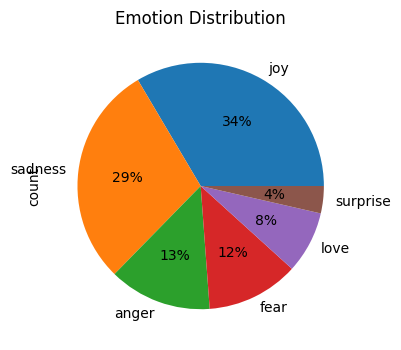

In [10]:
import matplotlib.pyplot as plt

# 绘制情绪分布图
df['label_name'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Emotion Distribution')
plt.show()

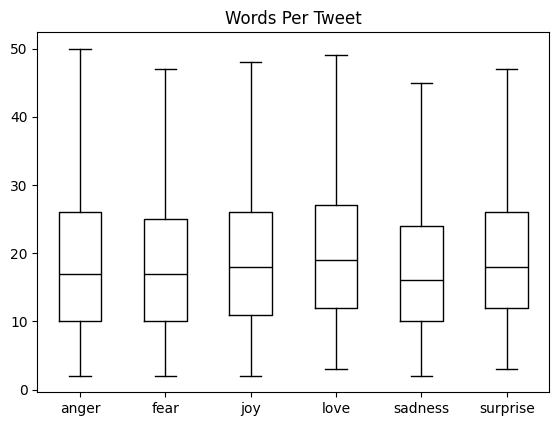

In [11]:
# 使用箱型图查看数据比重的调整
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot(column='Words Per Tweet', by='label_name',
        grid=False, showfliers=False,color='black')
plt.suptitle('')
plt.xlabel('')
plt.title('Words Per Tweet')
plt.show()

In [12]:
# 为了保证模型能够顺利被训练，可以调用`DatasetDict.reset_format()`函数重置数据集的格式
emotion.reset_format()

### 字符符号化（Character Tokenization）

In [13]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text) # 其实list()就是一个可用的tokenizer
print(tokenized_text, '\n')

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.'] 



In [14]:
# 使用字典做出映射表
vocab = {ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
vocab

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [15]:
# 使用此表取出序列中的索引
input_ids = [vocab[ch] for ch in tokenized_text]
print(input_ids, '\n')

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1] 



In [16]:
# 利用独热编码将索引转换为向量
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids) # 将输入ID转换为张量
one_hots = F.one_hot(input_ids, num_classes=len(vocab)) # 使用独热编码将索引转换为向量

print(one_hots.shape) # 生成一个[input_ids长度, vocab长度]的张量

torch.Size([38, 20])


In [17]:
# 打印其中之一的样本
print(f"Token: {tokenized_text[0]}")
print(f"Index: {input_ids[0]}")
print(f"One-Hot: {one_hots[0]}")

Token: T
Index: 5
One-Hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


为什么不使用字符符号化？原因是：当语料不断增大，拆分出来的单个字符也会越大，这样会占用非常多的空间。而且，我们人来理解语句是通过单词来理解的，而不是单个字符。所以，我们使用单词符号化。

### 词符号化

In [18]:
# 对字符串进行split而非用列表将其分割，从而进行tokenize
tokenized_text = text.split()
print(tokenized_text, '\n')

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.'] 



词符号化的弱点在于：即使我们处理了符号化带了的大量内存占用，但是另一个问题也诞生了，例如上面的结果：`NLP.`应该分为`NLP`和`.`，但是词符号化并没有处理这个问题。但是当这些错误的分词叠加在一起，产生的后果不可估量。譬如我们有由一百万个单词组成的文本，其中词表vocab的大小是一千，那么独特化之后的大小就是整整10亿的大小，这甚至超出了GPT2最大号模型的参数量！

### 子词符号化（Subword Tokenization）

In [19]:
from transformers import AutoTokenizer

model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [20]:
# 使用tokenizer.__call__(str)函数来讲字符串喂给tokenizer
tokenized_text = tokenizer(text,return_token_type_ids=False)
print(tokenized_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
# 由于tokenizer已经喂过了文本，所以我们可以抽取其中的input_ids将其映射回文本
tokens = tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [22]:
# 将token转换会字符串
print(
    # convert_tokens_to_string()函数接受的是分割好的token
    tokenizer.convert_tokens_to_string(tokens=tokens)
)
# 也可以使用tokenizer.decode()函数来完成这个过程
print(
    # 而decode()函数接受的是tokenized_text的input_ids
    tokenizer.decode(tokenized_text['input_ids'])
)

[CLS] tokenizing text is a core task of nlp. [SEP]
[CLS] tokenizing text is a core task of nlp. [SEP]


In [23]:
# 调用一些tokenizer常用的属性
print(f"Vocab Size: {tokenizer.vocab_size}")
print(f"Max Length: {tokenizer.model_max_length}")
print(f"Model I/O name (str): {tokenizer.model_input_names}")

Vocab Size: 30522
Max Length: 512
Model I/O name (str): ['input_ids', 'token_type_ids', 'attention_mask']


In [24]:
# 创建一个基于batch的函数来符号化整个语料
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True,return_token_type_ids=False)

In [25]:
print(tokenize(emotion['train'][:2])) # 传入两个样本

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [26]:
# 创建编码后的训练集
emotions_encoded = emotion.map(tokenize, batched=True)
# 打印训练集参数列
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


### Transformer的两种训练方式
- 特征提取器：在这种情况下，构建Transformer所需要的token嵌入以及编码信息、隐空间信息仅仅会被计算一次（模型第一个Epoch执行初始化时），而这些信息在第二次Epoch时将被冻结，而仅训练模型的分类头
- 完全微调：在这种情况下，模型的每一个迭代过程中，编码信息都将实时进行改变，因此分类头能够更好的理解新的信息，而非像上一种方式一样，需要通过前代的知识库来辅助分类。

In [27]:
# 从hugging face使用预训练模型
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkPoint = "distilbert-base-uncased"

model = AutoModel.from_pretrained(checkPoint).to(device)

In [28]:
# 使用tokenizer进行最后隐空间提取
text = "This is a test"
inputs = tokenizer(text,return_tensors='pt',return_token_type_ids=False) # 使用return_tensors='pt'返回pytorch张量

print(f"Input Tensor Shape : {inputs['input_ids'].size()}") # 生成的张量大小应为[batch, seq_len]


Input Tensor Shape : torch.Size([1, 6])


In [29]:
# 创建输入的键值对
# 由于值是张量，所以我们需要将其放入GPU中
inputs = {k:v.to(device) for k,v in inputs.items()} # 使用tokenized_text.items()来获得符号化后的所有属性

# 使用torch.no_grad()防止计算时对原模型梯度信息进行破坏

with torch.no_grad():
    outputs = model(**inputs)

# 打印输出
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [30]:
# 由于BaseModelOutput是一个组合类，所以我们可以使用点操作符来访问其中的属性
# 使用output.lsat_hidden_state来访问最后一层的隐藏状态

print(outputs.last_hidden_state.size()) # 输出最后一层的隐藏状态

torch.Size([1, 6, 768])


In [31]:
# 创建一个可以使用.map()方式进行批处理的函数
def extract_hidden_states(batch):
    # 将数据放在GPU上
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # 使用model()函数进行前向传播
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # 取出隐藏层输出
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [32]:
# 将datasets设置为pytorch格式
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label']) # 使用columns参数来指定我们需要的列

In [33]:
# 将特征提取函数映射到数据集上
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
# 创建特征矩阵
import numpy as np

x_train = np.array(emotions_hidden['train']['hidden_state'])
x_val = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_encoded['train']['label'])
y_val = np.array(emotions_encoded['validation']['label'])

In [35]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((16000, 768), (2000, 768), (16000,), (2000,))

### 可视化训练集中的情绪分布

使用`UMAP`算法将多维度特征向量映射为二维的独热化间断点，但在此之前我们需要使用`MinMaxScaler(极大极小值缩放)`将特征向量进行归一化处理，这样才能够更好的进行可视化。

In [ ]:
# 安装umap算法
!pip install umap-learn

In [36]:
# 导入umap和sklearn库
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 先将特征信息进行缩放
X_scaled = MinMaxScaler().fit_transform(x_train)

# 使用UMAP算法将特征降维到2维，使用余弦距离作为距离度量
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

# 创建用于展示信息的DataFrame
df_emb = pd.DataFrame(mapper.embedding_, columns=['x','y'])
df_emb['label'] = y_train
df_emb.head()

,x,y,label
0,3.875126,5.983035,0
1,-3.321778,4.801100,0
2,5.167006,2.766715,3
3,-2.619461,2.898891,2
4,-3.583137,3.041508,3


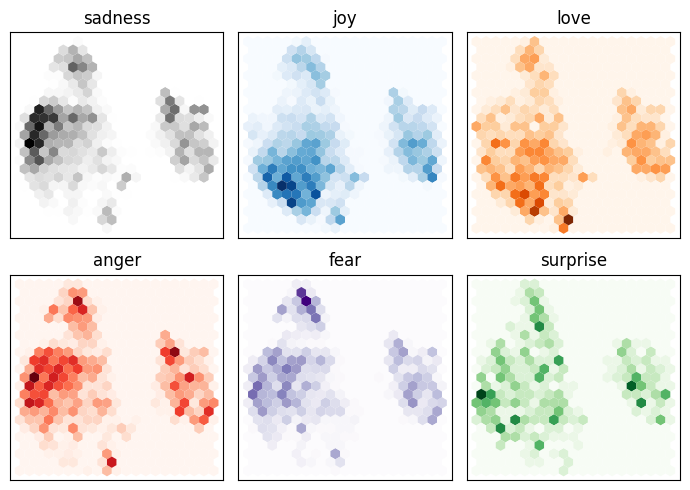

In [37]:
# 绘制箱型图
fig,axes = plt.subplots(2,df_emb['label'].unique().shape[0] // 2,figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys','Blues','Oranges','Reds','Purples','Greens']
labels = emotion['train'].features['label'].names

for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['x'],df_emb_sub['y'],gridsize=20,cmap=cmap,linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### 在CPU上训练一个简易的分类器

In [38]:
from sklearn.linear_model import LogisticRegression

# 创建逻辑回归模型
lr_clf = LogisticRegression(max_iter=3000)

# 训练模型
lr_clf.fit(x_train,y_train)

# 打印模型得分
print(f"Model final score: {lr_clf.score(x_val,y_val):.3f}")

Model final score: 0.634


In [39]:
# 基于独热分类器(Dummy Classifier)创建一个基准模型
from sklearn.dummy import DummyClassifier

# 创建一个基于独热分类器的模型
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_val, y_val)

0.352

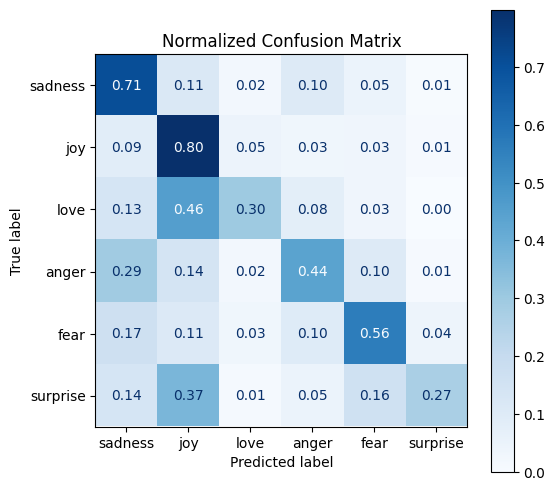

In [40]:
# 使用混淆矩阵来查看模型的性能
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax,values_format=".2f",cmap='Blues',colorbar=True)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# 使用模型进行预测
y_pred = lr_clf.predict(x_val)

# 绘制混淆矩阵
plot_confusion_matrix(y_pred=y_pred, y_true=y_val, labels=labels)

### 微调Transformer
与特征提取器不同，完全微调的方式会在每一个迭代过程中，实时更新编码信息，这样分类头能够更好的理解新的信息，而非像上一种方式一样，需要通过前代的知识库来辅助分类。

In [41]:
# 使用AutoModelForSequenceClassification模型加载DistilBERT

from transformers import AutoModelForSequenceClassification

num_labels = len(emotion['train'].features['label'].names) # 获取标签数量

model = AutoModelForSequenceClassification.from_pretrained(checkPoint, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# 定义损失函数
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels,preds)
    f1 = f1_score(labels,preds,average='weighted')
    return {"accuracy":acc, "f1":f1}

In [43]:
# 使用Trainer API来训练模型
from transformers import Trainer, TrainingArguments

# 定义超参数
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"

# 定义训练参数
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
    save_strategy="epoch",
)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.863600,0.325954,0.904500,0.903110
2,0.256400,0.224346,0.921500,0.921339


TrainOutput(global_step=500, training_loss=0.5599979858398437, metrics={'train_runtime': 93.473, 'train_samples_per_second': 342.345, 'train_steps_per_second': 5.349, 'total_flos': 718554424246272.0, 'train_loss': 0.5599979858398437, 'epoch': 2.0})

In [45]:
preds_output = trainer.predict(emotions_encoded['validation'])

preds_output.metrics

{'test_loss': 0.22434595227241516,
 'test_accuracy': 0.9215,
 'test_f1': 0.9213388282719949,
 'test_runtime': 1.605,
 'test_samples_per_second': 1246.117,
 'test_steps_per_second': 19.938}

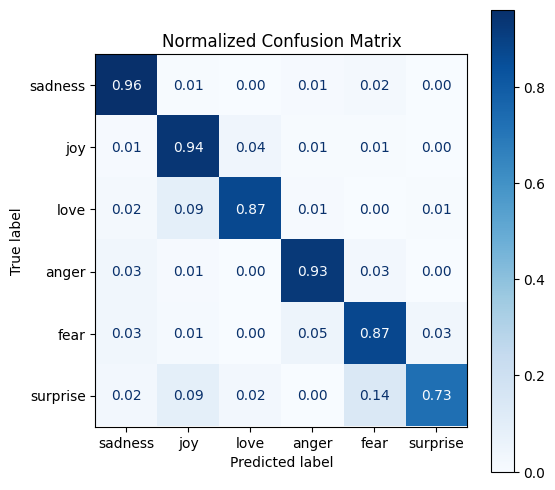

In [46]:
# 使用argmax()函数来获取预测的标签

y_preds = np.argmax(preds_output.predictions, axis=1)

# 绘制混淆矩阵

plot_confusion_matrix(y_pred=y_preds, y_true=y_val, labels=labels)

### 错误分析

In [57]:
# 使用交叉熵损失函数来替代默认损失函数
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 将所有的输入放在GPU上
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # 使用model()函数进行前向传播
    with torch.no_grad():
        outputs = model(**inputs)
        # 取出预测的标签
        pred_label = torch.argmax(outputs.logits,axis=-1)
        # 计算交叉熵损失
        loss = cross_entropy(outputs.logits,batch['label'].to(device),reduction="none")
    return {"loss":loss.cpu().numpy(), "pred_label":pred_label.cpu().numpy()}

In [59]:
# 使用map()函数来对数据集进行批处理
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [60]:
# 计算验证集的损失
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [67]:
# 将编码的数据集转换为pandas数据框
emotions_encoded.set_format('pandas')

In [72]:
# 指定features
cols = ['text','label','pred_label','loss']

df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['pred_label'] = (df_test['pred_label'].apply(label_int2str))

In [73]:
# 按照loss进行排序
df_test.sort_values(by='loss',ascending=False).head(10)

,text,label,pred_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.527825
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.477673
1274,i am going to several holiday parties and i ca...,joy,sadness,5.451574
465,i would eventually go in to these stores but i...,joy,fear,5.342969
765,i feel super awkward and out of place right now,joy,sadness,5.311315
1801,i feel that he was being overshadowed by the s...,love,sadness,5.058514
1111,im lazy my characters fall into categories of ...,joy,fear,5.020213
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.977380
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.941680
1509,i guess this is a memoir so it feels like that...,joy,fear,4.889440


In [74]:
# 检查模型最“有把握”的预测
df_test.sort_values(by='loss',ascending=True).head(10)

,text,label,pred_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.018870
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.019062
1263,i feel this way about blake lively,joy,joy,0.019231
632,i feel he is an terrific really worth bet,joy,joy,0.019692
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.020048
199,i feel invigorated full of energy ready for th...,joy,joy,0.020082
578,i got to christmas feeling positive about the ...,joy,joy,0.020235
400,i are just relaxing together and i feel ecstat...,joy,joy,0.020358
609,i was feeling festive yesterday,joy,joy,0.020441
1308,i feel there are very smart people that can co...,joy,joy,0.020547
